# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [105]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, udf, split, to_date, from_unixtime
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import unix_timestamp
from pyspark.sql import functions as f
from pyspark.sql import types as t
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
% matplotlib inline




In [106]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Churn Prediction") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [107]:
sparkify_data = 'mini_sparkify_event_data.json'

In [108]:
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [109]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [110]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [111]:
len(df.select(['userId','sessionId','artist','song']).where(df.userId == '').collect())

8346

In [112]:
len(df.select(['userId','sessionId','artist','song']).where(df.sessionId.isNull()).collect())

0

In [113]:
df = df.where(df.userId != '')

In [114]:
df.count()

278154

In [115]:
df.select(['userId', 'sessionId', 'artist']).where(df.gender == '').collect()

[]

In [116]:
df.select(['userId', 'sessionId', 'artist']).where(df.gender.isNull()).collect()

[]

In [117]:
df.select(['userId', 'sessionId', 'artist']).where(df.page == '').collect()

[]

**My Notes**: As we can see, there were `8,346` missing `userId` records in this dataset. For this, we removed the rows where these were missing.

In [118]:
df.select('ts').show(2)

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
+-------------+
only showing top 2 rows



In [119]:
df = df.withColumn('datetime', f.date_format(df.ts.cast(dataType=t.TimestampType()), "yyyy-MM-dd HH:mm:ss.SSS z"))


In [120]:
df.filter(df.sessionId == '141').select(['artist','length','sessionId','datetime','firstname','itemInSession','song','userId']).show()


+--------------------+---------+---------+--------------------+---------+-------------+--------------------+------+
|              artist|   length|sessionId|            datetime|firstname|itemInSession|                song|userId|
+--------------------+---------+---------+--------------------+---------+-------------+--------------------+------+
|                null|     null|      141|50719-01-27 21:10...|    Grant|            0|                null|   142|
|           The Kooks|169.45587|      141|50719-01-28 03:00...|    Grant|            1|         Love It All|   142|
|          Plasmatics| 256.7571|      141|50719-01-30 01:56...|    Grant|            2|          The Damned|   142|
|     Alliance Ethnik|195.94404|      141|50719-02-02 01:03...|    Grant|            3|SinceritÃÂ© Et J...|   142|
|     Tears For Fears|361.29914|      141|50719-02-04 07:13...|    Grant|            4|              Change|   142|
|                  B5|189.36118|      141|50719-02-08 11:30...|    Grant

In [121]:
# the dataframe has null values: lets fill with 0
df = df.fillna({'length':0})

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [122]:
df.select('page').dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [123]:
# Explore how many users are actually on the system, and how many have went on the page 'Cancellation Confirmation'

# groupby user and also by cancellation confirmation
print("Cancel Confirmation Total Count: ", df.filter(df['page'] == 'Cancellation Confirmation').count())

# how many users are on the system?
print("Users on the system: ", len(df.select('userId').dropDuplicates().collect()))


print("Cancel confirmation users: ", len(df.select('userId').filter(df['page'] == 'Cancellation Confirmation').collect()))


Cancel Confirmation Total Count:  52
Users on the system:  225
Cancel confirmation users:  52


**My Notes:** Above, we can confirm that 52 users have cancelled the service. We can also confirm that 226 users are using the service. These are all unique users on the system. Going forward, we can say that when a person goes to the `Cancel Confirmation` page, they are cancelling their service, thus they are **churning**. We can now move forward and create a column for the event of going to this page and label it as churn with the value of `1`.

In [124]:
# create a column called Churn and 1 being if the user ever had a Cancellation Confirmation and 0 if not
flag_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

df = df.withColumn("churned", flag_churn("page"))

In [125]:
df.select(['userId', 'churned']).where(df.churned == 1).count()

52

In [126]:
# collect all user Id's that are churned
userIds = []
for userId in df.filter(df.churned == 1).select('userId').collect():
    userIds.append(userId[0])

In [127]:
flag_churn_2 = udf(lambda x: 1 if x in (userIds) else 0, IntegerType())

In [128]:
df = df.withColumn("churned", flag_churn_2("userId"))

In [129]:
df.where(df.churned == 1).count()

44864

**Further Notes on Marking Churn:** Above, churn is categorized by users who have cancelled. This is by them going to the page `Cancel Confirmation`. To do this, first a udf was created to change all records with the page `Cancel Confirmation` to `1`. After this, `userIds` were pulled from that selection, and thus all users who cancelled were marked as `churned` (`0` to `1`).

In [130]:
df.groupby(['churned','page']).agg({'page':'count'}).orderBy('page').show()

+-------+--------------------+-----------+
|churned|                page|count(page)|
+-------+--------------------+-----------+
|      1|               About|         56|
|      0|               About|        439|
|      1|          Add Friend|        636|
|      0|          Add Friend|       3641|
|      1|     Add to Playlist|       1038|
|      0|     Add to Playlist|       5488|
|      1|              Cancel|         52|
|      1|Cancellation Conf...|         52|
|      0|           Downgrade|       1718|
|      1|           Downgrade|        337|
|      0|               Error|        220|
|      1|               Error|         32|
|      0|                Help|       1215|
|      1|                Help|        239|
|      0|                Home|       8410|
|      1|                Home|       1672|
|      1|              Logout|        553|
|      0|              Logout|       2673|
|      1|            NextSong|      36394|
|      0|            NextSong|     191714|
+-------+--

In [131]:
page_grouped = df.groupby(['churned','page']).agg({'page':'count'}).orderBy('page').toPandas()

In [132]:
# remove 'cancel' and 'cancel confirmation' as it is not in the churned 0 df
page_grouped = page_grouped[(page_grouped.page != 'Cancel')]
page_grouped = page_grouped[(page_grouped.page != 'Cancellation Confirmation')]

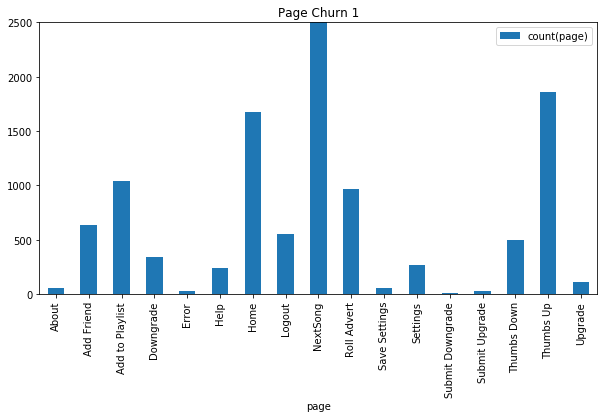

In [133]:
page_grouped[page_grouped.churned == 1].set_index('page').drop('churned', axis=1).plot(kind='bar',
                                                                                       figsize=(10,5),
                                                                                      title='Page Churn 1',
                                                                                      ylim=(0,2500));

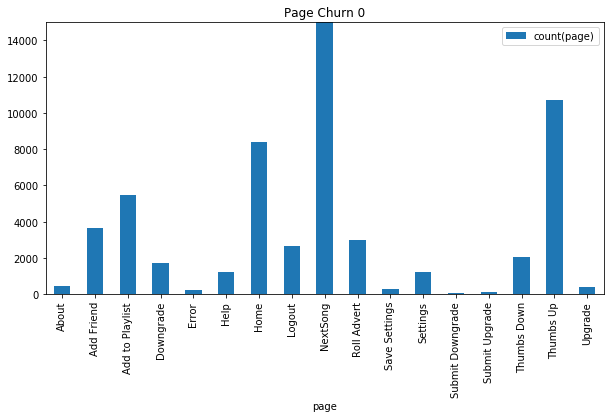

In [134]:
page_grouped[page_grouped.churned == 0].set_index('page').drop('churned', axis=1).plot(kind='bar',
                                                                                       figsize=(10,5),
                                                                                      title='Page Churn 0',
                                                                                      ylim=(0,15000));

From we can see with our findings, `churn 0` has more counts because of the distribution. However, we can see that other statistics are basically the same in comparison with each other.

**My Notes**: A user goes on, can be paid, the same session id exists, we can see how much songs they play per session

- How much songs does the user play per session?
- How much time is the user on per session?

To do these I would need to group by session and userid maybe then create a column for the time maybe?

In [135]:
df.groupby(['userId','sessionId']).count().orderBy('count', ascending=False).show()

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    91|     1840| 1282|
|   115|      316| 1080|
|   101|      635|  855|
|   120|      731|  758|
|   138|     2305|  699|
|    25|      827|  695|
|300002|      436|  676|
|    23|     2056|  668|
|   140|     1483|  656|
|    41|      377|  645|
|    62|     1150|  642|
|    61|      529|  637|
|   136|     2150|  631|
|    85|     1429|  627|
|    29|     1455|  615|
|    96|     1446|  602|
|    51|      236|  599|
|100008|      132|  591|
|    85|     2266|  588|
|    96|     2300|  583|
+------+---------+-----+
only showing top 20 rows



Above, we can see the amount of actions or pages that a user would have been on at one time. For example, we can see that user `91` is the highest, which would mean they were on the site for `1282` actions. This means that they could have been playing songs, or other actions.

In [136]:
df.where(df.page == 'NextSong').groupby(['userId','churned']).count().orderBy('count', ascending=False).show()

+------+-------+-----+
|userId|churned|count|
+------+-------+-----+
|    39|      0| 8002|
|    92|      0| 5945|
|   140|      0| 5664|
|300011|      0| 4619|
|   124|      0| 4079|
|300021|      0| 3816|
|300017|      0| 3632|
|    85|      0| 3616|
|    42|      0| 3573|
|     6|      0| 3159|
|    29|      1| 3028|
|200023|      0| 2955|
|    54|      1| 2841|
|   100|      0| 2682|
|     9|      0| 2676|
|    91|      0| 2580|
|   126|      0| 2577|
|300015|      0| 2524|
|    98|      0| 2401|
|    74|      0| 2400|
+------+-------+-----+
only showing top 20 rows



In [137]:
df.where(df.page == 'NextSong').groupby(['userId','churned']).count().orderBy('count', ascending=True).show()

+------+-------+-----+
|userId|churned|count|
+------+-------+-----+
|   156|      0|    3|
|   135|      0|    6|
|   125|      1|    8|
|100011|      1|   11|
|100024|      1|   22|
|100006|      1|   26|
|300003|      0|   27|
|    22|      0|   28|
|    68|      0|   29|
|   133|      0|   32|
|    90|      0|   37|
|   134|      0|   37|
|   122|      1|   41|
|    64|      0|   46|
|100003|      1|   51|
|100017|      1|   52|
|    34|      0|   53|
|100019|      1|   62|
|   116|      0|   63|
|200007|      0|   65|
+------+-------+-----+
only showing top 20 rows



Now, if we look at the reverse, there are more who have churned. This just gives some evidence that persons who have churned play less songs than those who have not. This is not conclusive, but shows that it may be helpful in being a feature.

Above the users with the most songs played and showing whether they have **churned** or not. We can see for the top users the majority have not churned.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Columns to be used:
- Gender: string (M/F)
- Length
- Level (Paid/Free)
- Page: Has to be explored more because there are a number of categories in here to use.
- NextSong: create a udf so that it can show the amount of `nextSongs` played.




In [138]:
male_female = udf(lambda x: 1 if x == "M" else 0, IntegerType())
paid_free = udf(lambda x: 1 if x == "Paid" else 0, IntegerType())
next_song = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())

In [139]:
# df = df.withColumn('male_female', male_female('gender'))
# df = df.withColumn('paid_free', paid_free('level'))
df = df.withColumn('next_song', next_song('page'))

In [140]:
# lets use string index for the gender
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='gender', outputCol='genderCatIndex')
df = indexer.fit(df).transform(df)
df.groupby('genderCatindex').count().show()

+--------------+------+
|genderCatindex| count|
+--------------+------+
|           0.0|154578|
|           1.0|123576|
+--------------+------+



In [141]:
# use StringIndexer on page column
level_indexer = StringIndexer(inputCol='page', outputCol='pageCatIndex')
df = level_indexer.fit(df).transform(df)
df.groupby('pageCatIndex').count().show()

+------------+------+
|pageCatIndex| count|
+------------+------+
|         8.0|  2055|
|         0.0|228108|
|         7.0|  2546|
|        18.0|    52|
|         1.0| 12551|
|         4.0|  4277|
|        11.0|   499|
|        14.0|   252|
|         3.0|  6526|
|         2.0| 10082|
|        17.0|    52|
|        10.0|  1454|
|        13.0|   310|
|         6.0|  3226|
|         5.0|  3933|
|        15.0|   159|
|         9.0|  1514|
|        16.0|    63|
|        12.0|   495|
+------------+------+



In [142]:
# lets use string index for the gender
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='level', outputCol='levelCatIndex')
df = indexer.fit(df).transform(df)
df.groupby('levelCatindex').count().show()

+-------------+------+
|levelCatindex| count|
+-------------+------+
|          0.0|222433|
|          1.0| 55721|
+-------------+------+



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

As can be seen above, using Logistic Regression, we are getting `84%` accuracy without any parameter tuning. This algorithm seems so far to be getting good results. However, as we will continue to see these results are not accurate. 

As we can see above with all of the models, we are getting the exact same results. This is because there is an imbalance as it pertains to churn. As we can see, in the dataset is not predicting any to be churned. This is because of the difference between churn and non churn. To correct this we would have to do some downsampling.

### Downsample

In [143]:
df.groupby('churned').count().show()

+-------+------+
|churned| count|
+-------+------+
|      1| 44864|
|      0|233290|
+-------+------+



Here is the imbalance of churn. `44,864:233,290`.

In [144]:
churn = df.groupby(['churned']).agg({'churned':'count'}).toPandas()

In [145]:
churn

,churned,count(churned)
0,1,44864
1,0,233290


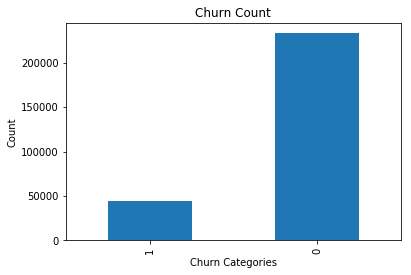

In [146]:
ax = churn.set_index('churned').plot(kind='bar', title='Churn Count', legend=False);
ax.set_xlabel("Churn Categories");
ax.set_ylabel("Count");


The distribution for Churn is very unbalanced. This can really throw off the modeling so we will balance this.

In [147]:
df.sampleBy('churned', fractions={0:44864/233290, 1:1.0}).groupby('churned').count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|44864|
|      0|44866|
+-------+-----+



In [148]:
df_balance = df.sampleBy('churned', fractions={0:44864/233290, 1:1.0})

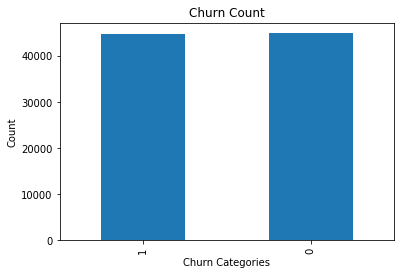

In [149]:
churn_balanced = df_balance.groupby(['churned']).agg({'churned':'count'}).toPandas()
ax = churn_balanced.set_index('churned').plot(kind='bar', title='Churn Count', legend=False);
ax.set_xlabel("Churn Categories");
ax.set_ylabel("Count");


We downsampled the dataset so that the `churn` category can be more balanced.

In [150]:
# seems like there is a correlation between users who churn and the amount of time they are playing songs
df_balance.groupby(['userId', 'churned', 'level']).sum('length').orderBy('sum(length)', ascending=True).show()

+------+-------+-----+------------------+
|userId|churned|level|       sum(length)|
+------+-------+-----+------------------+
|   142|      0| free|               0.0|
|300021|      0| free|               0.0|
|300014|      0| free|               0.0|
|    44|      0| free|               0.0|
|300009|      0| free|         200.80281|
|   156|      0| free|         221.64853|
|300023|      0| free|          239.3073|
|   135|      0| free|         466.93786|
|300016|      0| free|         496.32563|
|300018|      0| free|         882.17942|
|    37|      0| free|1011.7467700000001|
|200008|      0| free|        1031.07783|
|   139|      0| free|1073.8659400000001|
|   133|      0| free|        1105.91818|
|    60|      0| free|         1118.3786|
|300012|      0| free|        1131.67447|
|   132|      0| free|        1192.59202|
|300002|      0| free|        1300.03367|
|300005|      0| free|         1341.4116|
|    34|      0| free|1448.0952499999999|
+------+-------+-----+------------

As seen above, there is about 5 times more persons who did not churned compared to those who have churned. This creates a problem with the models and accuracy. As we have seen, there were no churn predictions because of this. To remedy this we had to downsample. We used the `sampleBy` method and now there is more of a 1:1 ratio although we lost about 188,000 records.

In [151]:
assembler = VectorAssembler(inputCols=['genderCatIndex', 'pageCatIndex', 'levelCatIndex'], outputCol="features")
df_balance_output = assembler.transform(df_balance)

In [152]:
df_balance_training = df_balance_output.select(col('churned').alias('label'), col('features'))

### Logistic Regression

In [153]:
# Split dataset into train, test
training, testing = df_balance_training.randomSplit([0.8, 0.2])

In [154]:
lr = LogisticRegression(maxIter=80, regParam=0.3, elasticNetParam=0.0)
lrModel = lr.fit(training)
results = lrModel.transform(testing)


In [155]:
print(results.where(results.label == results.prediction).count())
print(results.count())

10477
18079


In [156]:
print(results.filter(results.label == results.prediction).count() / results.count())

0.5795121411582499


In [157]:
results.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 7092|
|       1.0|10987|
+----------+-----+



In [158]:
lrModel.summary.fMeasureByLabel(0.0)

[0.6048954759293975, 0.5702492641648271]

### Random Forest

In [159]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(training)
predictions = rfModel.transform(testing)

In [160]:
print(predictions.filter(predictions.label == predictions.prediction).count() / predictions.count())

0.5797333923336467


### Decision Tree

In [161]:
dt = DecisionTreeClassifier(maxDepth=3, labelCol='label')
dtModel = dt.fit(training)
predictions = dtModel.transform(testing)

In [162]:
print(predictions.filter(predictions.label == predictions.prediction).count() / predictions.count())

0.5795121411582499


--------

### Pipelines

In [163]:
train, test = df_balance.randomSplit([0.8, 0.2])


In [164]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer
indexer = StringIndexer(inputCol='gender', outputCol='genderCatIndexy')
level_indexer = StringIndexer(inputCol='page', outputCol='pageCatIndexy')
si = StringIndexer(inputCol='level', outputCol='levelCatIndexy')
assembler = VectorAssembler(inputCols=['genderCatIndex', 'pageCatIndex', 'levelCatIndex'], outputCol="features")
lr = LogisticRegression(labelCol='churned')


transformed = Pipeline(stages=[assembler, lr]).fit(train).transform(test)




In [165]:
transformed.filter(transformed.churned == transformed.prediction).count() / transformed.count()

0.5849246793974352

---------

In [166]:
dt = DecisionTreeClassifier(maxDepth=3, labelCol='label')
dtModel = dt.fit(training)
predictions = dtModel.transform(testing)

In [167]:
predictions.filter(predictions.label == predictions.prediction).count() / predictions.count()

0.5795121411582499

-------

In [168]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(training)
predictions = rfModel.transform(testing)

In [169]:
predictions.filter(predictions.label == predictions.prediction).count() / predictions.count()

0.5797333923336467

--------

### Model Tuning for Logistic Regression

In [170]:
logistic_r = LogisticRegression()

In [171]:
paramGrid = ParamGridBuilder()\
    .addGrid(logistic_r.regParam, [0.1, 0.01, 0.5, 0.9])\
    .addGrid(logistic_r.fitIntercept, [True, False])\
    .addGrid(logistic_r.maxIter, [1,10,100])\
    .addGrid(logistic_r.threshold, [0.5, 0.1, 0.8])\
    .build()

tvs = TrainValidationSplit(estimator=logistic_r,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol='label'),
                           trainRatio=0.8)

model = tvs.fit(training)

preds = model.transform(testing)

In [172]:
preds.filter(preds.label == preds.prediction).count() / preds.count()

0.5795121411582499

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.